In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [2]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [3]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [5]:
def fit_and_plot_a_country(country, src = pd.DataFrame(), p0_log =[5,20,40000], p0_exp = [0.5,0.5,0.5], cases = True, predictions = True):
    if src.empty:
        if cases :
            try:
                df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv")
            except Exception as e:
                print("Data could not be fetched")
                print(e)
                return None
        else:
            # if cases is false, data calculated will be related to deaths
            try:
                df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv")
            except Exception as e:
                print("Data could not be fetched")
                print(e)
                return None
    else:
        df = src
    
    if country not in list(df.columns):
        print("Please check your country is in the data")
        return None
    
    df = df[['date',country]]
    df = df[True != df[country].isna()]
    df = df[df[country] > 0]
    last_updating = list(df.date)[-1]
    print("Last updating of data :",last_updating)
    df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
#    if country == 'World':
#         plt.plot(df.iloc[:,0], df.iloc[:,1],label="Real data",color="red", linestyle = 'dashed')
#         plt.ylabel("Amount of infected people")
#         plt.xlabel("Days from 1 January 2020")
#         return None
    if predictions: 
        try:
            fit = curve_fit(logistic_model,x,y,p0=p0_log, maxfev=2000)
        except Exception as e:
            print("To get a result, please change the parameters in the list p0_log")
            print(e)
            return None
        errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
        a,b,c = fit[0]
        sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
        print("Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): ")
        print("a = ", fit[0][0], " +/- ", errors[0])
        print("b = ", fit[0][1], " +/- ", errors[1])
        print("c = ", fit[0][2], " +/- ", errors[2] , "(This also means the amount of cases at the end.)" )
        first_day = datetime.strptime("2020-01-01", '%Y-%m-%d')
        last_day = first_day + timedelta(days=sol)
        last_day = datetime.strftime(last_day,'%Y-%m-%d')
        if cases:
            print("Last day of infections : ", last_day , " (approximately)")
        try:  
            exp_fit = curve_fit(exponential_model,x,y,p0=p0_exp)
        except Exception as e:
            print("To get a results, please change the parameters in the list p0_exp")
            print(e)
            return None
        pred_x = list(range(max(x),sol))
        plt.rcParams['figure.figsize'] = [7, 7]
        plt.rc('font', size=14)
        # Actual DATA
        plt.scatter(df.iloc[:,0], df.iloc[:,1],label="Actual data", color="#2554C7")
        # Predicted DATA with logistic model
        plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic curve", alpha = 0.7, color="green")
        # Predicted DATA with exponential model
        plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential curve",alpha=0.6, color = "red")
        plt.legend()
        plt.xlabel("Days from 1 January 2020")
        if cases:
            plt.ylabel("Amount of infected people")
        else:
            plt.ylabel("Amount of deaths")   
        plt.ylim((min(y)*0.9,c*1.1))
        plt.show()
        return None
    else:
        plt.plot(df.iloc[:,0], df.iloc[:,1],label="Real data",color="red", linestyle = 'dashed')
        plt.xlabel("Days from 1 January 2020")
        return None
    

In [5]:
for i in pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv").columns:
    print(i)

date
World
Afghanistan
Albania
Algeria
Andorra
Angola
Anguilla
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
British Virgin Islands
Brunei
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
Colombia
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Democratic Republic of Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Faeroe Islands
Fiji
Finland
France
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guam
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
International
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Liberia

Last updating of data : 2020-03-27
Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): 
a =  5.061701163315361  +/-  0.06982202461300609
b =  81.92888126895592  +/-  0.21394008354551955
c =  115886.92996663402  +/-  2251.3195315002613 (This also means the amount of cases at the end.)
Last day of infections :  2020-05-21  (approximately)


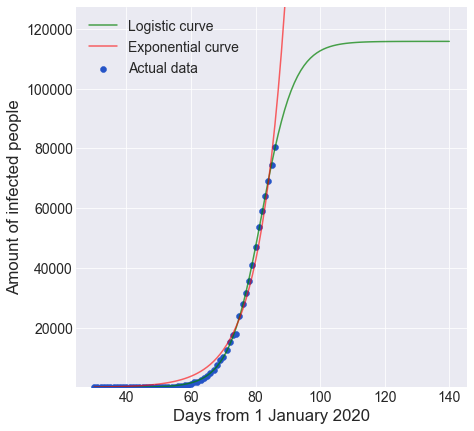

In [11]:
fit_and_plot_a_country(country = 'Italy', cases = True , predictions = True)   